#### **Devoir 2 -  Méthodes économétriques en finance**

Membres de l'équipe:

Bruno Généreux                                                                                                                                                             
Michael Hoang  
Philippe Thériault

Devoir fait avec l'aide de ChatGPT.


#### **Importation des packages et des modules**

In [62]:
import wrds
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import norm
from statsmodels.tsa.api import VAR

#### **Problème 1 - Machine Learning**

##### **Importation des données**

In [63]:
# Importation des données

# Connexion à WRDS
db = wrds.Connection()
print("Connexion à WRDS réussie.")

# Récupération des PERMNO pour les tickers sélectionnés
tickers = ['MA', 'BA', 'PFE']
permno_df = db.raw_sql(f"""
    SELECT permno, ticker 
    FROM crsp.stocknames 
    WHERE ticker IN ({', '.join(f"'{t}'" for t in tickers)})
""")

# Extraction des prix ajustés et rendements quotidiens
prices_df = db.raw_sql(f"""
    SELECT date, permno, prc 
    FROM crsp.dsf 
    WHERE date BETWEEN '2013-12-02' AND '2022-12-02' 
    AND permno IN ({', '.join(map(str, permno_df['permno'].tolist()))})
""")
returns_df = db.raw_sql(f"""
    SELECT date, permno, ret 
    FROM crsp.dsf 
    WHERE date BETWEEN '2013-12-02' AND '2022-12-02' 
    AND permno IN ({', '.join(map(str, permno_df['permno'].tolist()))})
""")
market_df = db.raw_sql("""
    SELECT date, vwretd 
    FROM crsp.dsi 
    WHERE date BETWEEN '2013-12-02' AND '2022-12-02'
""")
print("Données extraites avec succès.")

# Fermeture de la connexion
db.close()

# Formatage des dates
returns_df['date'] = pd.to_datetime(returns_df['date'])
prices_df['date'] = pd.to_datetime(prices_df['date'])
market_df['date'] = pd.to_datetime(market_df['date'])

# Organisation des données
returns_pivot = returns_df.pivot(index='date', columns='permno', values='ret')
prices_pivot = prices_df.pivot(index='date', columns='permno', values='prc')
ticker_map = dict(zip(permno_df['permno'], permno_df['ticker']))
returns_pivot.rename(columns=ticker_map, inplace=True)
prices_pivot.rename(columns=ticker_map, inplace=True)
returns_pivot['Market'] = market_df.set_index('date')['vwretd']
returns_pivot.dropna(inplace=True)
prices_pivot.dropna(inplace=True)

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Connexion à WRDS réussie.
Données extraites avec succès.


##### **a. Construction d’un échantillon de régression à partir d’une série temporelle**

In [64]:
import pandas as pd

def construire_lags_et_lags_carres(ser: pd.Series, n: int) -> pd.DataFrame:
    """
    Construit un DataFrame pour la régression temporelle à partir d'une série de rendements.

    Paramètres
    ----------
    ser : pd.Series
        Série temporelle univariée (par exemple les rendements journaliers d'une action).
    n : int
        Nombre de périodes de décalage à inclure dans le modèle.

    Retour
    ------
    pd.DataFrame
        Un DataFrame contenant :
        - 'y' : la valeur actuelle,
        - 'lag_1', ..., 'lag_n' : les n valeurs décalées de la série,
        - 'lag2_1', ..., 'lag2_n' : les carrés des lags.
        Les lignes avec des valeurs manquantes (NaN) sont supprimées.
    """
    df = pd.DataFrame({'y': ser})

    for i in range(1, n + 1):
        df[f'lag_{i}'] = ser.shift(i)
    for i in range(1, n + 1):
        df[f'lag2_{i}'] = ser.shift(i) ** 2

    df.dropna(inplace=True)
    return df

# Liste des tickers à traiter
tickers = ["BA", "MA", "PFE"]
n = 3  # nombre de lags

# Application de la fonction à chaque série, stockée dans un dictionnaire
df_lags_all = {}
for ticker in tickers:
    serie = returns_pivot[ticker]
    df_lags_all[ticker] = construire_lags_et_lags_carres(serie, n)

# Affichage des 5 premières lignes pour chaque ticker
for ticker, df_lags in df_lags_all.items():
    print(f"--- {ticker} ---")
    display(df_lags.head())


--- BA ---


,y,lag_1,lag_2,lag_3,lag2_1,lag2_2,lag2_3
date,,,,,,,
2013-12-05,0.009354,-0.003788,-0.0161,-0.00067,0.000014,0.000259,0.0
2013-12-06,0.018459,0.009354,-0.003788,-0.0161,0.000087,0.000014,0.000259
2013-12-09,-0.003699,0.018459,0.009354,-0.003788,0.000341,0.000087,0.000014
2013-12-10,-0.007276,-0.003699,0.018459,0.009354,0.000014,0.000341,0.000087
2013-12-11,-0.008527,-0.007276,-0.003699,0.018459,0.000053,0.000014,0.000341


--- MA ---


,y,lag_1,lag_2,lag_3,lag2_1,lag2_2,lag2_3
date,,,,,,,
2013-12-05,0.004451,-0.007864,-0.002672,-0.006164,0.000062,0.000007,0.000038
2013-12-06,0.009275,0.004451,-0.007864,-0.002672,0.00002,0.000062,0.000007
2013-12-09,0.000514,0.009275,0.004451,-0.007864,0.000086,0.00002,0.000062
2013-12-10,0.006259,0.000514,0.009275,0.004451,0.0,0.000086,0.00002
2013-12-11,0.035306,0.006259,0.000514,0.009275,0.000039,0.0,0.000086


--- PFE ---


,y,lag_1,lag_2,lag_3,lag2_1,lag2_2,lag2_3
date,,,,,,,
2013-12-05,-0.00064,0.001602,-0.019164,0.003152,0.000003,0.000367,0.00001
2013-12-06,0.00928,-0.00064,0.001602,-0.019164,0.0,0.000003,0.000367
2013-12-09,0.001268,0.00928,-0.00064,0.001602,0.000086,0.0,0.000003
2013-12-10,-0.0076,0.001268,0.00928,-0.00064,0.000002,0.000086,0.0
2013-12-11,-0.022017,-0.0076,0.001268,0.00928,0.000058,0.000002,0.000086


##### **1b. Estimation d’un modèle OLS sur les valeurs décalées et leurs carrés**

In [65]:
def estimer_modele_ols(df: pd.DataFrame, n: int):
    """
    Applique une régression OLS à partir d'un DataFrame univarié contenant une série temporelle.

    Paramètres
    ----------
    df : pd.DataFrame
        Un DataFrame avec une seule colonne contenant une série temporelle (ex: rendement).
    n : int
        Le nombre de lags (et de carrés de lags) à inclure.

    Retour
    ------
    RegressionResults
        Objet de résultats de statsmodels OLS.
    """
    import statsmodels.api as sm

    # Extraire la série
    ser = df.iloc[:, 0]

    # Générer les données explicatives
    data = construire_lags_et_lags_carres(ser, n)

    # Définir y et X
    y = data["y"]
    X = data.drop(columns=["y"])

    # Ajouter constante
    X = sm.add_constant(X)

    # Conversion explicite en float
    X = X.astype(float)
    y = y.astype(float)

    # Estimation
    model = sm.OLS(y, X).fit()

    return model

# Appel de la fonction définie à la question 1b : on applique une régression OLS
# à chacune des séries ['BA', 'MA', 'PFE'] en utilisant 3 périodes de décalage (n = 3).
# Cela correspond à un modèle de type :
# y_t en fonction des valeurs décalées y_{t-1}, y_{t-2}, y_{t-3}, ainsi que de leurs carrés :
# y_{t-1}², y_{t-2}², y_{t-3}², avec ajout d'une constante.

tickers = ["BA", "MA", "PFE"]
n = 3  # nombre de périodes de décalage

for ticker in tickers:
    print(f"\n=== Résultats OLS pour {ticker} ===")
    resultats = estimer_modele_ols(returns_pivot[[ticker]], n)

    # Affiche un résumé complet du modèle estimé (coefficients, erreurs standard, R², etc.)
    print(resultats.summary())


=== Résultats OLS pour BA ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     17.36
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           9.99e-20
Time:                        17:23:02   Log-Likelihood:                 5158.6
No. Observations:                2265   AIC:                        -1.030e+04
Df Residuals:                    2258   BIC:                        -1.026e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009

#### Comparaison des performances OLS entre BA, MA et PFE

| Élément                | BA     | MA     | PFE    | Interprétation |
|------------------------|--------|--------|--------|----------------|
| R² (R-squared)         | 0.044  | 0.011  | 0.005  | Le modèle explique le mieux la variance pour BA. |
| R² ajusté              | 0.042  | 0.008  | 0.002  | Même tendance : modèle le plus performant pour BA. |
| F-statistic            | 17.36  | 4.05   | 1.80   | Seul BA est très significatif (p < 0.0001). MA est aussi significatif mais faible. |
| p-valeur globale       | <0.0001 | 0.00047 | 0.0946 | Le modèle n’est pas significatif pour PFE au seuil de 5 %. |
| Durbin-Watson          | 2.001  | 2.000  | 1.998  | Aucune autocorrélation pour les trois titres. |

#### Comparaison des coefficients OLS – BA, MA et PFE

| Variable   | BA (coef / p-val) | MA (coef / p-val) | PFE (coef / p-val) | Interprétation |
|------------|-------------------|-------------------|--------------------|----------------|
| const      | 0.0009 / 0.084    | 0.0010 / 0.011    | 0.0005 / 0.154     | Moyenne conditionnelle. Faible significativité dans tous les cas. |
| lag_1      | 0.0498 / 0.018    | -0.0873 / 0.000   | -0.0385 / 0.071    | AR(1) positif pour BA (significatif), négatif pour MA (fort), et modéré pour PFE (faible). |
| lag_2      | 0.0969 / 0.000    | -0.0070 / 0.742   | 0.0073 / 0.733     | Très significatif pour BA, insignifiant pour MA et PFE. |
| lag_3      | -0.0109 / 0.609   | -0.0068 / 0.752   | 0.0419 / 0.050     | Aucune significativité claire, sauf limite pour PFE. |
| lag2_1     | 1.2485 / 0.000    | 0.7807 / 0.042    | -0.7270 / 0.205    | Très significatif pour BA, marginal pour MA, pas significatif pour PFE. |
| lag2_2     | -1.0893 / 0.000   | -0.0654 / 0.865   | 0.2396 / 0.677     | Fortement significatif uniquement pour BA. |
| lag2_3     | -0.8918 / 0.000   | -0.9220 / 0.016   | 0.4913 / 0.391     | BA et MA montrent une non-linéarité significative à J-3, PFE non. |


##### **1c. Estimation Ridge avec visualisation du chemin des coefficients**

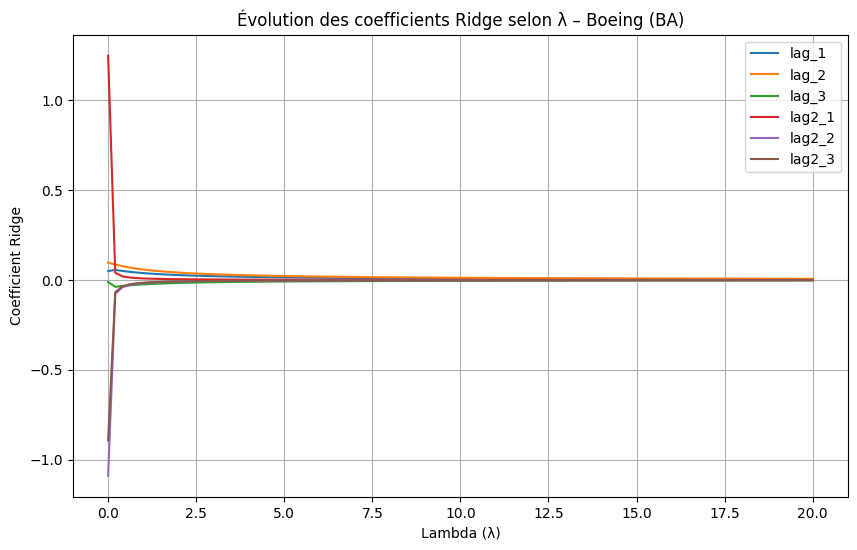

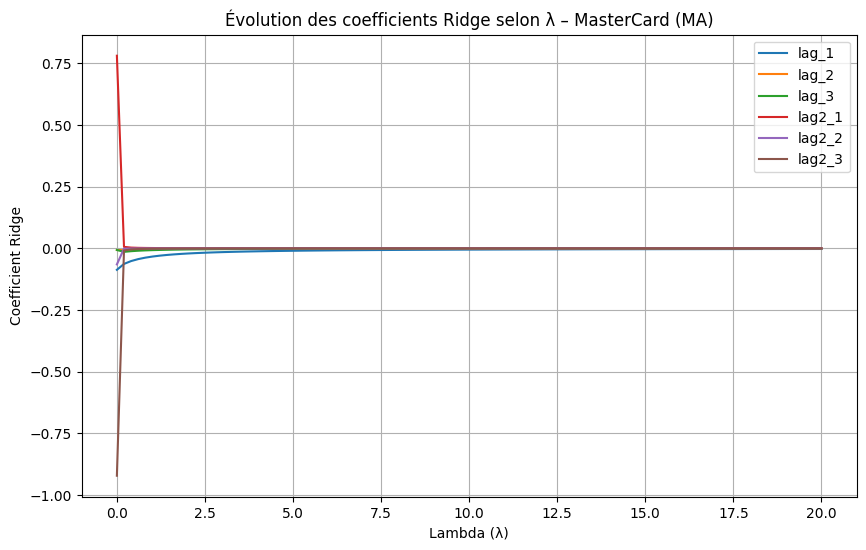

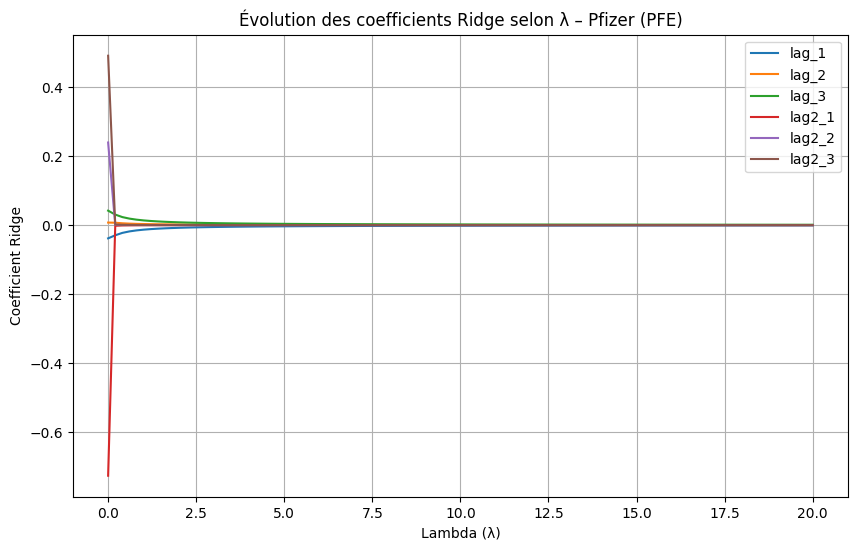

In [66]:
def ridge_path(df: pd.DataFrame, s: float, n: int, titre_graphique="Évolution des coefficients Ridge selon λ"):
    """
    Estime et trace les coefficients de régression Ridge pour différents niveaux de régularisation (lambda).
    
    Paramètres
    ----------
    df : pd.DataFrame
        DataFrame avec la variable cible en première colonne, les prédicteurs ensuite (lags et carrés).
    s : float
        Valeur maximale du paramètre de régularisation lambda.
    n : int
        Nombre de valeurs de lambda à tester (et donc de régressions Ridge à effectuer).
    titre_graphique : str
        Titre à afficher pour le graphique généré (optionnel).
    
    Retour
    ------
    ridge_coefs_df : pd.DataFrame
        DataFrame contenant les coefficients estimés pour chaque lambda testé.
        Les lignes correspondent aux différentes valeurs de lambda.
        La première colonne est lambda, les autres sont les coefficients.
    """

    # Séparer y (target) et X (prédicteurs)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].values
    X = sm.add_constant(X)

    # Générer n valeurs de lambda entre 0 et s
    lambdas = np.linspace(0, s, n)

    # Liste pour stocker les coefficients
    ridge_coefs = []

    # Régression Ridge pour chaque lambda
    for l in lambdas:
        model = Ridge(alpha=l, fit_intercept=False)
        model.fit(X, y)
        ridge_coefs.append(model.coef_)

    ridge_coefs = np.array(ridge_coefs)  # matrice n x (p+1)

    # Création du DataFrame de résultats
    coef_names = ['const'] + list(df.columns[1:])
    ridge_coefs_df = pd.DataFrame(ridge_coefs, columns=coef_names)
    ridge_coefs_df.insert(0, "lambda", lambdas)

    # Tracer le graphique (sans la constante)
    plt.figure(figsize=(10, 6))
    for col in ridge_coefs_df.columns[2:]:  # on saute lambda et constante
        plt.plot(ridge_coefs_df["lambda"], ridge_coefs_df[col], label=col)
    plt.xlabel("Lambda (λ)")
    plt.ylabel("Coefficient Ridge")
    plt.title(titre_graphique)
    plt.legend()
    plt.grid(True)
    plt.show()

    return ridge_coefs_df


# Application de la fonction à chaque titre : BA, MA, PFE
# On utilise ici 3 périodes de décalage (n = 3)

# Tickers et noms d'entreprise associés
entreprises = {
    "BA": "Boeing (BA)",
    "MA": "MasterCard (MA)",
    "PFE": "Pfizer (PFE)"
}

s = 20
n_lambdas = 100
n_lags = 3

coefs_ridge_all = {}

for ticker, nom in entreprises.items():
    # Construction du DataFrame avec lags
    df_ticker = construire_lags_et_lags_carres(returns_pivot[ticker], n_lags)

    # Appliquer la fonction ridge_path. On utilise s = 20 comme valeur maximale de régularisation,
    # et n = 100 pour obtenir 100 modèles Ridge avec des lambda uniformément espacés entre 0 et 20.
    # La fonction retourne un DataFrame contenant les coefficients pour chaque lambda,
    # et affiche en plus un graphique montrant l'évolution de chaque coefficient selon λ.
    titre = f"Évolution des coefficients Ridge selon λ – {nom}"
    coefs_ridge_all[ticker] = ridge_path(df_ticker, s=s, n=n_lambdas, titre_graphique=titre)

### Interprétation des résultats 

Nous avons appliqué une régression Ridge aux rendements journaliers de trois entreprises (BA, MA, PFE), en régressant chaque série sur ses trois lags et les carrés de ces lags. La pénalisation (lambda) varie de 0 (OLS) à 20 (forte régularisation).

Observation générale
Pour les trois entreprises, on observe un phénomène classique de shrinkage : les coefficients régressés tendent vers zéro à mesure que λ augmente.

Cela permet de gérer la multicolinéarité, fréquente entre lags et leurs carrés, et d’améliorer la stabilité des prédictions.

#### Boeing (BA)
Les coefficients lag_1 et lag_2 restent dominants jusqu’à λ ≈ 3, confirmant leur importance déjà identifiée en OLS.

Les variables quadratiques (lag2_1, lag2_2) se contractent plus rapidement, ce qui suggère qu’elles apportent moins de robustesse sous régularisation.

Au-delà de λ = 5, le modèle se simplifie énormément, tous les coefficients étant presque nuls.

#### MasterCard (MA)
Tous les coefficients diminuent très rapidement, dès les plus faibles valeurs de λ.

Aucun prédicteur ne semble véritablement persister, ce qui indique une faible robustesse individuelle.

Cela conforte les résultats OLS : faible R² et coefficients peu significatifs.

#### Pfizer (PFE)
La décroissance des coefficients est plus douce que pour MA, mais aucun prédicteur ne domine visiblement.

Le shrinkage affecte les variables quadratiques et linéaires de manière similaire.

Cela traduit une certaine instabilité ou redondance dans les prédicteurs, sans dominance claire.

#### Interprétation théorique
Ridge agit comme un contrôle de la complexité : en pénalisant les grands coefficients, il réduit la variance du modèle au prix d’un biais contrôlé.

Ce type de régularisation est recommandé en présence :

de multicolinéarité (présente ici avec les lags et leurs carrés),

d’un grand nombre de prédicteurs par rapport aux observations (cas modéré ici),

ou d’un signal faible, comme c’est le cas pour MA.

#### Conclusion
Boeing ressort comme le titre avec le modèle le plus robuste : certains coefficients conservent du poids même sous forte régularisation.

MasterCard est le plus affecté par la pénalisation, ce qui suggère un modèle instable ou peu informatif.

Pfizer se situe entre les deux, sans variable dominante mais avec une décroissance plus graduelle.

Ces résultats confirment les observations OLS et soulignent l’intérêt de Ridge pour explorer la stabilité des prédicteurs dans un contexte financier bruité.

##### **1d. Optimisation de λ en régression Ridge avec validation croisée**

In [67]:
def selection_ridge_lambda(df: pd.DataFrame, s: float, n: int, LOOCV: bool):
    """
    Sélectionne le paramètre de régularisation optimal (λ) pour une régression Ridge
    à l’aide de la validation croisée (LOOCV ou 10-fold), puis estime les coefficients.

    Paramètres
    ----------
    df : pd.DataFrame
        DataFrame contenant la variable cible en première colonne, suivie des prédicteurs.
    s : float
        Valeur maximale de la pénalité lambda (λ).
    n : int
        Nombre de valeurs de λ à tester.
    LOOCV : bool
        Si True, utilise la validation croisée Leave-One-Out. Sinon, 10-fold CV.

    Retour
    ------
    meilleur_lambda : float
        Le λ qui minimise l'erreur de validation croisée.
    meilleurs_coefficients : np.array
        Les coefficients estimés avec ce λ optimal.
    """
    # Séparer y (cible) et X (prédicteurs)
    y = df.iloc[:, 0].values
    X = df.iloc[:, 1:].values
    X = sm.add_constant(X)  # Ajout de la constante (intercept)

    # Générer n valeurs de λ entre 10^-8 et s
    lambdas = np.linspace(1e-8, s, n)

    # Choisir le type de validation croisée
    if LOOCV:
        cv = LeaveOneOut()
    else:
        cv = KFold(n_splits=10, shuffle=False)  # Pas de shuffle en séries temporelles

    # Stocker les erreurs de validation
    erreurs_cv = []

    for l in lambdas:
        model = Ridge(alpha=l, fit_intercept=False)
        # Évaluer l'erreur quadratique moyenne par validation croisée
        score = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        erreurs_cv.append(-score.mean())  # Inverser le signe car sklearn retourne des scores négatifs

    # Identifier le λ optimal
    idx_min = np.argmin(erreurs_cv)
    meilleur_lambda = lambdas[idx_min]

    # Estimer le modèle final avec ce λ optimal
    modele_final = Ridge(alpha=meilleur_lambda, fit_intercept=False)
    modele_final.fit(X, y)
    meilleurs_coefficients = modele_final.coef_

    return meilleur_lambda, meilleurs_coefficients


# Paramètres communs pour les deux tests
s = 20        # valeur maximale de régularisation lambda
n = 50        # nombre de valeurs de lambda à tester 

# Liste des tickers à analyser
tickers = ["BA", "MA", "PFE"]

for ticker in tickers:
    print(f"\n{'='*20} Analyse Ridge pour {ticker} {'='*20}\n")

    # Construction du DataFrame avec lags pour la série courante
    # On utilise ici 3 périodes de décalage pour rester cohérent avec les questions précédentes.
    df_ticker = construire_lags_et_lags_carres(returns_pivot[ticker], 3)

    # Cas 1 : Validation croisée Leave-One-Out (LOOCV = True)
    print("=== Validation croisée Leave-One-Out (LOOCV) ===")
    meilleur_lambda_loocv, coefficients_loocv = selection_ridge_lambda(df_ticker, s=s, n=n, LOOCV=True)
    print("Lambda optimal (LOOCV) :", meilleur_lambda_loocv)
    print("Coefficients Ridge associés (LOOCV) :")
    print(coefficients_loocv)

    # Cas 2 : Validation croisée en 10 blocs (10-fold CV)
    print("\n=== Validation croisée 10-fold ===")
    meilleur_lambda_kfold, coefficients_kfold = selection_ridge_lambda(df_ticker, s=s, n=n, LOOCV=False)
    print("Lambda optimal (10-fold) :", meilleur_lambda_kfold)
    print("Coefficients Ridge associés (10-fold) :")
    print(coefficients_kfold)



==================== Analyse Ridge pour BA ====================

=== Validation croisée Leave-One-Out (LOOCV) ===
Lambda optimal (LOOCV) : 4.081632661020408
Coefficients Ridge associés (LOOCV) :
[ 0.00052285  0.01734582  0.02597196 -0.00967048  0.00238906 -0.00406823
 -0.00377956]

=== Validation croisée 10-fold ===
Lambda optimal (10-fold) : 20.0
Coefficients Ridge associés (10-fold) :
[ 0.00052919  0.00451803  0.00672751 -0.0023272   0.00051658 -0.00082233
 -0.00077882]

==================== Analyse Ridge pour MA ====================

=== Validation croisée Leave-One-Out (LOOCV) ===
Lambda optimal (LOOCV) : 1.6326530704081632
Coefficients Ridge associés (LOOCV) :
[ 0.00090279 -0.02458855 -0.00176714 -0.0054817   0.00062688 -0.00021352
 -0.00113624]

=== Validation croisée 10-fold ===
Lambda optimal (10-fold) : 0.4081632751020408
Coefficients Ridge associés (10-fold) :
[ 0.00093583 -0.05162689 -0.00539357 -0.0116897   0.00274981 -0.00077349
 -0.00446526]

==================== Analyse

#### Résultats et interprétation – Validation croisée Ridge (BA, MA, PFE)

Nous avons appliqué une régression Ridge à trois titres boursiers : Boeing (BA), MasterCard (MA) et Pfizer (PFE), en utilisant 3 périodes de décalage (lags). L’objectif était d’identifier, à l’aide de validation croisée, la meilleure valeur du paramètre de pénalisation λ (lambda), qui contrôle l’intensité du shrinkage (rétrécissement des coefficients).

Deux types de validation croisée ont été comparés :
- LOOCV (Leave-One-Out Cross Validation) : sensible à la structure locale, plus flexible.
- 10-fold CV : plus robuste, tend à régulariser davantage.

##### Analyse comparative

| Titre | λ (LOOCV) | λ (10-fold) | Complexité du modèle |
|-------|-----------|-------------|-----------------------|
| BA    | 4.08      | 20.00       | LOOCV retient une structure, 10-fold régularise fortement. |
| MA    | 1.63      | 0.41        | Les deux méthodes gardent des coefficients similaires. |
| PFE   | 20.00     | 3.27        | PFE montre peu de structure dans ses rendements. |

---

#### Analyse détaillée par titre

##### Boeing (BA)

Méthode 1 – LOOCV :
- λ optimal : 4.08
- Coefficients : [0.00052, 0.01735, 0.02597, -0.00967, 0.00239, -0.00407, -0.00378]
- Certains coefficients comme lag_1 et lag_2 restent significatifs.
- Les coefficients quadratiques sont présents mais de faible amplitude.
- Cela suggère une structure modérée et exploitable.

Méthode 2 – 10-fold CV :
- λ optimal : 20.0
- Tous les coefficients sont proches de zéro.
- Forte régularisation ⇒ signal perçu comme faible ou instable.

Interprétation :
- LOOCV conserve plus de structure (modèle plus flexible).
- 10-fold choisit une solution plus stable (forte pénalisation).
- Le compromis biais-variance est clairement illustré ici.

##### MasterCard (MA)

Méthode 1 – LOOCV :
- λ optimal : 1.63
- Coefficients : [0.00090, -0.0246, -0.0018, -0.0055, 0.0006, -0.0002, -0.0011]

Méthode 2 – 10-fold CV :
- λ optimal : 0.41
- Coefficients similaires.

Interprétation :
- Les deux méthodes donnent des modèles comparables.
- La structure est stable.
- Faible régularisation ⇒ les lags ont un pouvoir prédictif cohérent.

##### Pfizer (PFE)

Méthode 1 – LOOCV :
- λ optimal : 20.0
- Tous les coefficients sont proches de 0.

Méthode 2 – 10-fold CV :
- λ optimal : 3.27
- Coefficients légèrement plus présents, mais toujours très faibles.

Interprétation :
- Peu de dynamique dans les rendements de PFE.
- La régression Ridge conclut à une absence de structure prédictive significative.

---

#### Conclusion générale

- BA : Comporte une structure, mais instable. LOOCV la retient, 10-fold l'écrase.
- MA : Structure plus régulière, les deux méthodes convergent.
- PFE : Faible structure ⇒ les coefficients sont systématiquement réduits.

Le choix de λ influence fortement l’interprétation du modèle. L'analyse justifie pleinement l'usage de Ridge pour contrôler la complexité du modèle, notamment en présence de multicolinéarité ou d’instabilité structurelle.


#### **Problème 2 - Modèles AR**

##### **2a. Statistiques descriptives et visualisation temporelle des données PJM**

Unités des variables :
- Zonal COMED price : $/MWh (prix de l’électricité)
- System load forecast : MW (prévision de charge)
- Zonal COMED load forecast : MW (prévision de charge)

Statistiques descriptives enrichies pour les variables numériques (arrondies à 4 décimales) :


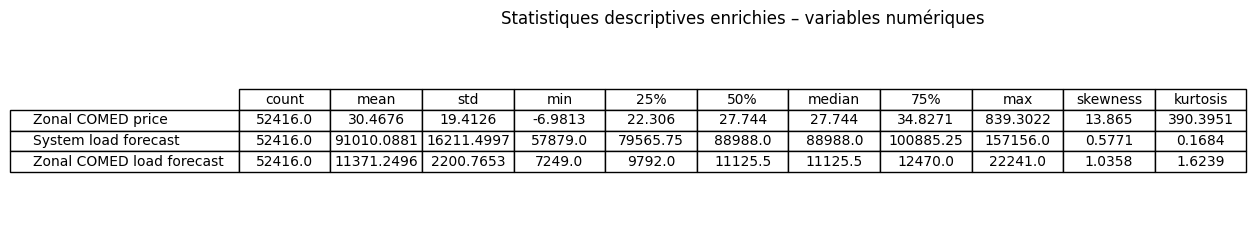

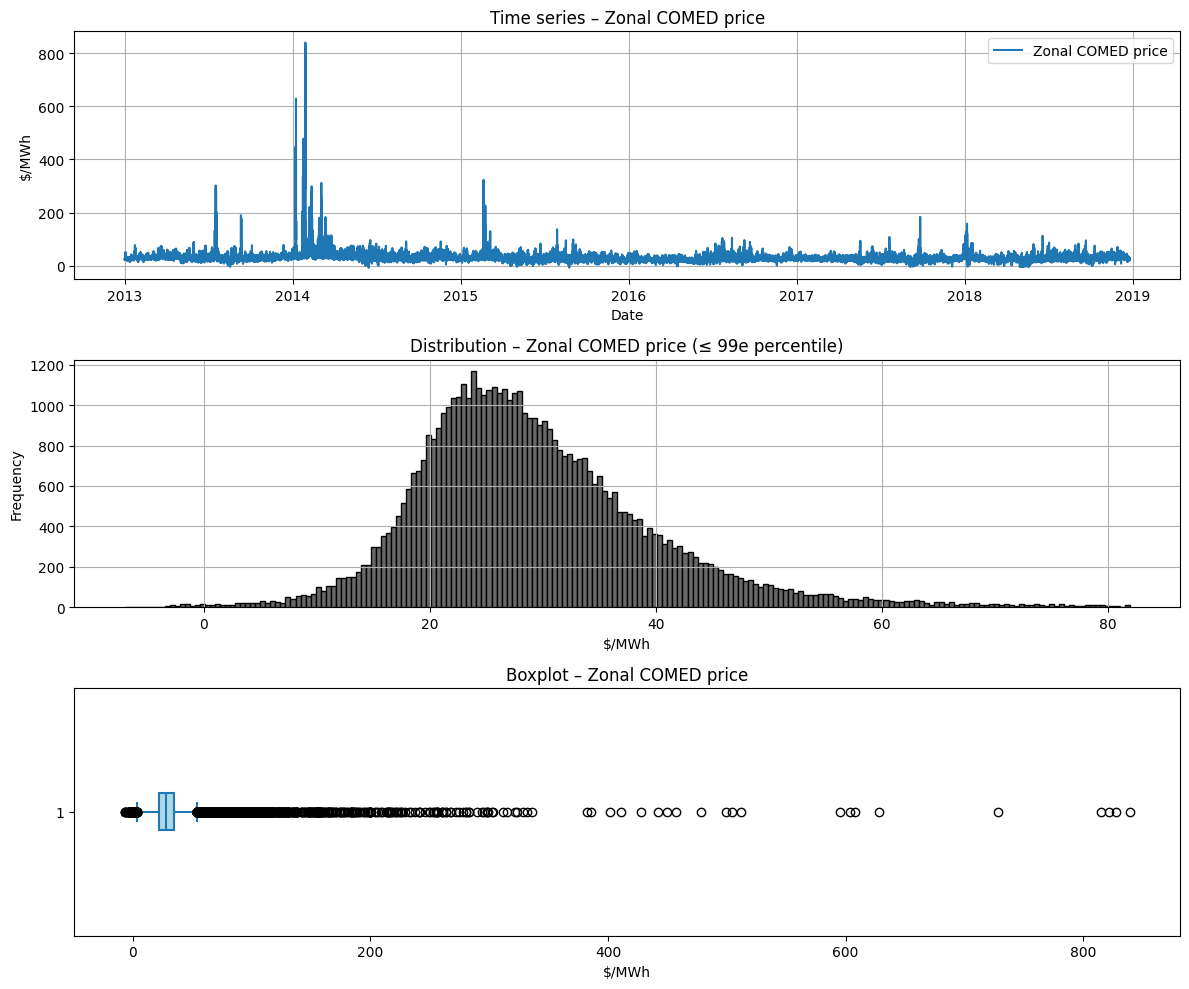

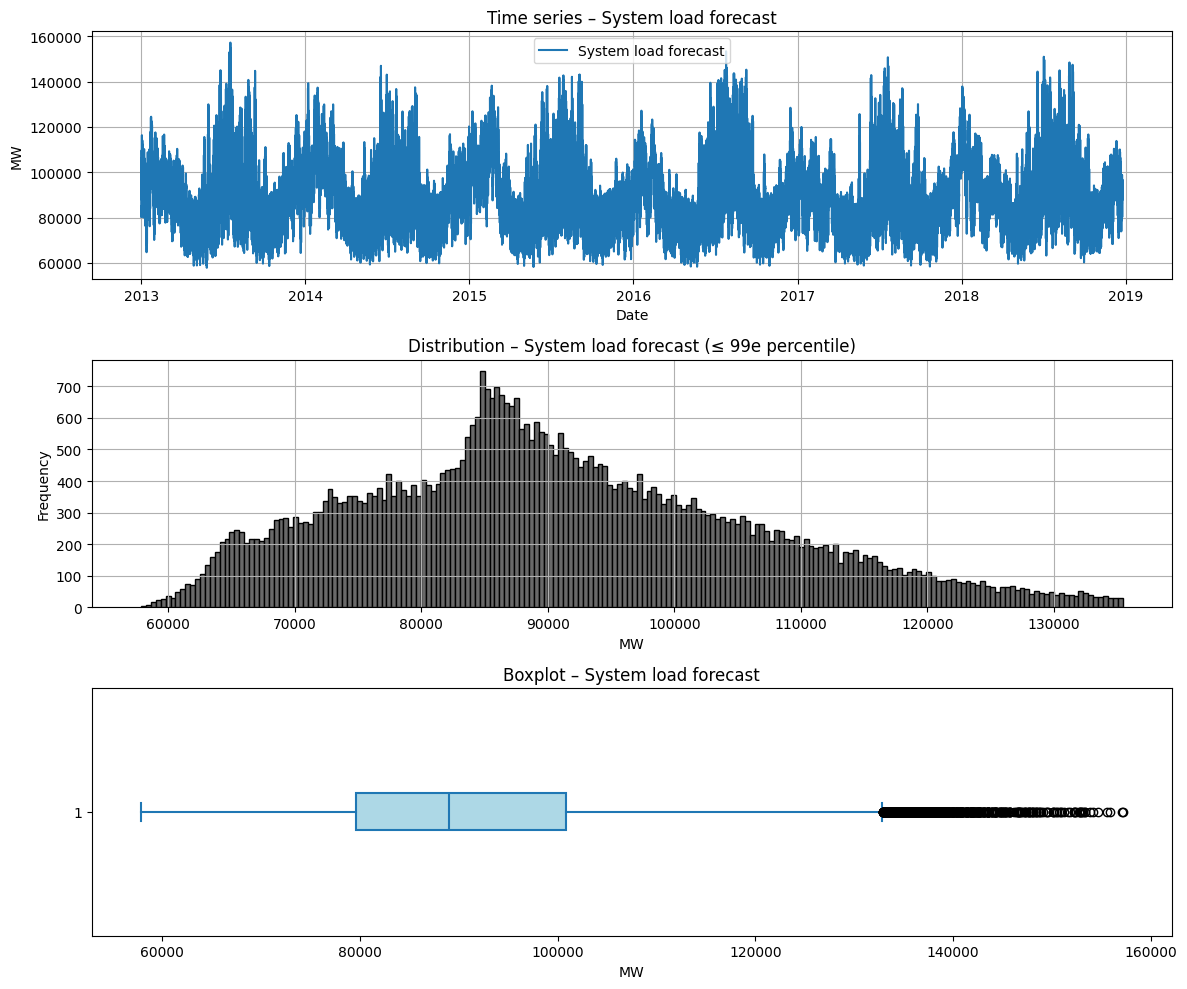

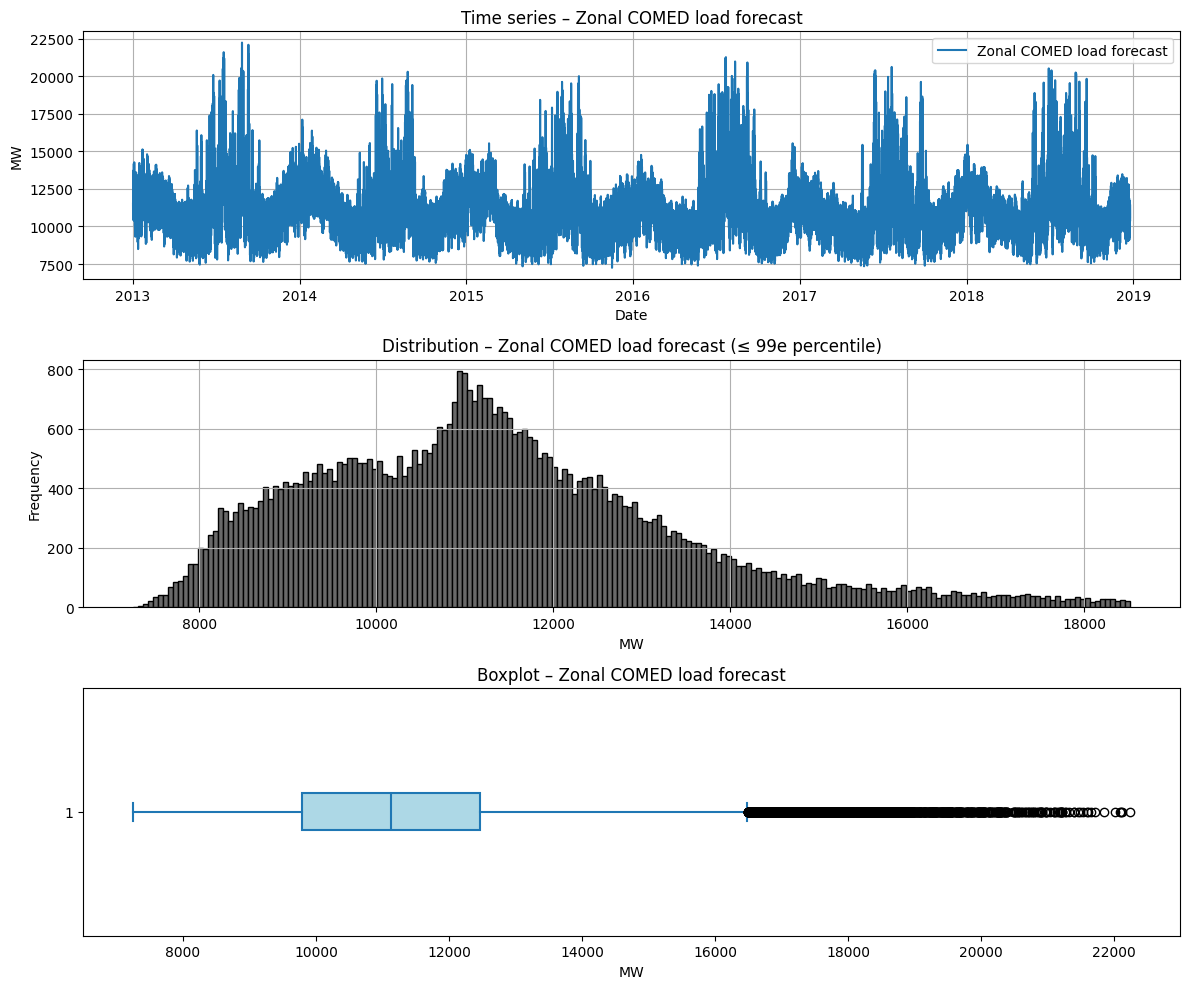

In [7]:
# Chargement des données
df_pjm = pd.read_csv("PJM.csv")

# Nettoyage des noms de colonnes
df_pjm.columns = df_pjm.columns.str.strip()

# Correction manuelle du nom de colonne contenant une faute de frappe dans le fichier source
# Cela nous empêche d'utiliser directement les noms de colonnes de façon dynamique sans ajustement.
df_pjm.rename(columns={
    "Zonal COMED load foecast": "Zonal COMED load forecast"
}, inplace=True)

# Conversion de la colonne "Date" en datetime et mise en index
df_pjm["Date"] = pd.to_datetime(df_pjm["Date"])
df_pjm.set_index("Date", inplace=True)

# Sélection des colonnes numériques
colonnes_numeriques = df_pjm.select_dtypes(include="number").columns

# Affichage des unités
print("Unités des variables :")
for col in colonnes_numeriques:
    if "price" in col.lower():
        print(f"- {col} : $/MWh (prix de l’électricité)")
    elif "load" in col.lower():
        print(f"- {col} : MW (prévision de charge)")
    else:
        print(f"- {col} : (unité non spécifiée)")

# Statistiques descriptives enrichies
print("\nStatistiques descriptives enrichies pour les variables numériques (arrondies à 4 décimales) :")
stats = df_pjm[colonnes_numeriques].describe().T
stats["median"] = df_pjm[colonnes_numeriques].median()
stats["skewness"] = df_pjm[colonnes_numeriques].skew()
stats["kurtosis"] = df_pjm[colonnes_numeriques].kurt()
stats = stats[["count", "mean", "std", "min", "25%", "50%", "median", "75%", "max", "skewness", "kurtosis"]]
stats = stats.round(4)

# Affichage du tableau enrichi avec espace optimisé
fig, ax = plt.subplots(figsize=(13, 2.5))  # Hauteur réduite
ax.axis('off')

table = ax.table(cellText=stats.values,
                 colLabels=stats.columns,
                 rowLabels=stats.index,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Titre rapproché + tight layout
plt.title("Statistiques descriptives enrichies – variables numériques", pad=5)
plt.tight_layout()
plt.show()


# Boucle de création des 3 graphiques par variable
for col in colonnes_numeriques:
    unit = "$/MWh" if "price" in col.lower() else "MW" if "load" in col.lower() else ""
    nb_obs = df_pjm[col].dropna().shape[0]
    bins = 200 if nb_obs > 50000 else 60 if nb_obs > 5000 else 30

    fig, axs = plt.subplots(3, 1, figsize=(12, 10))

    # Série temporelle
    axs[0].plot(df_pjm[col], label=col, color='tab:blue')
    axs[0].set_title(f"Time series – {col}")
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel(unit)
    axs[0].legend()
    axs[0].grid(True)

    # Histogramme tronqué au 99e percentile
    limite_99 = df_pjm[col].quantile(0.99)
    axs[1].hist(df_pjm[col][df_pjm[col] <= limite_99].dropna(),
                bins=bins, color='dimgray', edgecolor='black')
    axs[1].set_title(f"Distribution – {col} (≤ 99e percentile)")
    axs[1].set_xlabel(unit)
    axs[1].set_ylabel("Frequency")
    axs[1].grid(True)

    # Boxplot en bleu
    box = axs[2].boxplot(df_pjm[col].dropna(), vert=False, patch_artist=True)
    axs[2].set_title(f"Boxplot – {col}")
    axs[2].set_xlabel(unit)

    for element in ['boxes', 'whiskers', 'caps', 'medians']:
        for line in box[element]:
            line.set_color('tab:blue')
            line.set_linewidth(1.5)

    for patch in box['boxes']:
        patch.set_facecolor('lightblue')

    plt.tight_layout()
    plt.show()


### Interprétation des résultats – Statistiques descriptives et graphiques (question 2a)

#### Statistiques numériques

Les trois variables observées présentent des comportements statistiques très distincts.

- Zonal COMED price ($/MWh) :
  - Distribution fortement asymétrique à droite (skewness ≈ 13.87), indiquant quelques valeurs extrêmes très élevées.
  - Très forte kurtosis (≈ 390), donc présence de queues épaisses : les prix connaissent parfois des pics très rares mais extrêmes.
  - L’écart-type est élevé par rapport à la moyenne, ce qui souligne une forte volatilité.
  - L’histogramme tronqué confirme une concentration des prix autour de 20 à 40 $ par MWh, avec de rares observations dépassant 400 \$ par MWh
  - Le boxplot met clairement en évidence des outliers majeurs.

- System load forecast (MW) et Zonal COMED load forecast (MW) :
  - Ces séries sont plus symétriques (skewness ≈ 0.58 et 1.03), avec des kurtosis plus proches de la normale.
  - Leur moyenne et médiane sont très proches, ce qui confirme la quasi-normalité de la distribution (en dehors de quelques extrêmes pour COMED).
  - La Zonal COMED load forecast montre tout de même une légère asymétrie positive.

#### Évolution temporelle

- Les séries de charge (load forecast) montrent une saisonnalité nette dans le temps :
  - On observe une cyclicité à court terme (hebdomadaire, journalière),
  - et probablement une saisonnalité annuelle, liée à la température extérieure.

- Pour les prix de l’électricité, la série temporelle est plus erratique :
  - Bien que les prix soient généralement stables, des spikes ponctuels apparaissent,
  - Cela correspond probablement à des périodes de tension sur le réseau électrique, typiquement en été ou lors de vagues de froid.

#### Contexte géographique – COMED

- COMED (Commonwealth Edison) est un important distributeur d’électricité situé dans le nord de l’Illinois, incluant Chicago et ses environs.
- Le climat y est caractérisé par :
  - des hivers froids et rigoureux,
  - des étés chauds et humides.
- Ces conditions contribuent à une forte saisonnalité énergétique :
  - hausse de la demande en hiver (chauffage) et en été (climatisation),
  - impact sur les prix et sur les prévisions de charge.

#### Conclusion

Les distributions des charges sont globalement normales, tandis que la distribution des prix est clairement non normale, avec une asymétrie et une kurtosis très élevées. Cela justifie l’usage de transformations ou d’approches robustes dans les étapes de modélisation ultérieures. Les dynamiques temporelles confirment la saisonnalité et la volatilité typique du marché électrique, en lien avec les caractéristiques climatiques régionales.

---

#### Références

- PJM Learning Center – Territory Served: https://learn.pjm.com/three-priorities/keeping-the-lights-on/pjm-territory.aspx
- Site officiel de COMED : https://www.comed.com/


##### **2b. Modélisation AR avec sélection d’ordre par critère d’information**

In [8]:
def estimer_modele_ar(y, lag, max_lag=None):
    """
    Estime un modèle AR(p) avec lag fixe ou sélectionné manuellement selon un critère d'information.

    Paramètres
    ----------
    y : pd.Series
        Série temporelle à modéliser.
    lag : int ou str
        Si int : ordre AR fixé.
        Si str : 'aic', 'bic' ou 'hqic' pour sélectionner l'ordre optimal.
    max_lag : int
        Nombre maximum de lags à tester si lag est un critère.

    Retour
    ------
    dict contenant :
        - 'critere' : str ou None,
        - 'lag_selectionne' : int,
        - 'resultats' : AutoRegResults
    """
    if not isinstance(y, pd.Series):
        raise ValueError("y doit être une pd.Series")

    if isinstance(lag, int):
        model = AutoReg(y, lags=lag, old_names=False)
        results = model.fit()
        return {
            "critere": None,
            "lag_selectionne": lag,
            "resultats": results
        }

    elif isinstance(lag, str):
        if lag not in ['aic', 'bic', 'hqic']:
            raise ValueError("lag doit être 'aic', 'bic' ou 'hqic'")
        if max_lag is None:
            raise ValueError("max_lag doit être spécifié si lag est un critère")

        best_ic = np.inf
        best_result = None
        best_lag = None

        for p in range(1, max_lag + 1):
            try:
                model = AutoReg(y, lags=p, old_names=False)
                result = model.fit()
                current_ic = getattr(result, lag)
                if current_ic < best_ic:
                    best_ic = current_ic
                    best_result = result
                    best_lag = p
            except Exception:
                continue

        return {
            "critere": lag,
            "lag_selectionne": best_lag,
            "resultats": best_result
        }

    else:
        raise ValueError("lag doit être un entier ou une chaîne valide ('aic', 'bic', 'hqic')")

    
# Supposons que la série a déjà été nettoyée dans df_pjm
# On extrait la série cible
y = df_pjm["System load forecast"].dropna()

# Application de la fonction sur 5 variantes
resultats_ar = {
    "AR(1)": estimer_modele_ar(y, lag=1),
    "AR(3)": estimer_modele_ar(y, lag=3),
    "AIC": estimer_modele_ar(y, lag="aic", max_lag=40),
    "BIC": estimer_modele_ar(y, lag="bic", max_lag=40),
    "HQIC": estimer_modele_ar(y, lag="hqic", max_lag=40)
}

# Affichage des résumés pour chacun des modèles estimés
for nom, res in resultats_ar.items():
    print("=" * 60)
    print(f"Modèle : {nom}")
    print(f"Critère utilisé : {res['critere']}")
    print(f"Ordre (lag) sélectionné : {res['lag_selectionne']}")
    print(res['resultats'].summary())


c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\s

Modèle : AR(1)
Critère utilisé : None
Ordre (lag) sélectionné : 1
                             AutoReg Model Results                              
Dep. Variable:     System load forecast   No. Observations:                52416
Model:                       AutoReg(1)   Log Likelihood             -502784.941
Method:                 Conditional MLE   S.D. of innovations           3545.548
Date:                  Sun, 23 Mar 2025   AIC                        1005575.882
Time:                          23:37:41   BIC                        1005602.482
Sample:                      01-01-2013   HQIC                       1005584.196
                           - 12-24-2018                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2203.4262     88.309     24.951      0.000    2030.344    2376.509
System loa


### Interprétation des résultats – Estimation des modèles AR

Nous avons estimé cinq modèles autorégressifs (AR) sur la série System load forecast : deux avec un ordre fixé (AR(1) et AR(3)), et trois avec une sélection automatique de l'ordre à l'aide de critères d'information (AIC, BIC, HQIC), avec max_lag = 40.

AR(1) et AR(3)

- Le modèle AR(1) capte bien la forte dépendance de la série, avec un coefficient proche de 0.976, très significatif. La racine du polynôme AR est légèrement supérieure à 1, ce qui suggère une persistance extrême, voire une quasi-non-stationnarité.
- Le modèle AR(3) améliore grandement l’ajustement : les coefficients sont significatifs, l’écart-type des innovations diminue (de 3545 à 1487), et les critères AIC/BIC sont nettement plus faibles. Cela montre que les deux premiers retards supplémentaires sont utiles pour capter la dynamique.

Modèles avec sélection automatique (AIC, BIC, HQIC)

- Les trois critères (AIC, BIC, HQIC) ont tous sélectionné un modèle AR(40), c’est-à-dire avec le maximum de retards autorisé dans notre test.
- Cela reflète une structure temporelle très riche, probablement liée à la présence de cycles multiples (journaliers, hebdomadaires).
- Malgré le nombre élevé de paramètres, les coefficients estimés sont pour la plupart très significatifs, et les erreurs standard restent faibles.
- La racine dominante reste proche de 1, et le modèle conserve une forte composante persistante.

Fréquence de la série

- Les warnings indiquant "No frequency information was provided" sont normaux et liés au fait que la fréquence (freq) n’est pas explicitement définie dans l’index du DataFrame. statsmodels infère automatiquement une fréquence horaire, ce qui est cohérent avec la structure des données PJM.

Conclusion

- Le modèle AR(1) est simple mais insuffisant pour bien capturer la dynamique.
- Le modèle AR(3) est plus performant, mais reste limité.
- Les critères d'information (surtout le BIC, plus conservateur) sélectionnent un modèle très riche (AR(40)), ce qui suggère que la série System load forecast contient une forte structure de dépendance à long terme.
- Ce comportement est cohérent avec les données de charge électrique, qui présentent des schémas de consommation répétitifs et saisonniers.

| Modèle     | Critère utilisé | Lag sélectionné | Log-Likelihood | S.D. innovations | AIC        | BIC        | HQIC       |
|------------|------------------|------------------|----------------|------------------|------------|------------|------------|
| AR(1)      | Aucun            | 1                | -502784.94     | 3545.55          | 1005575.88 | 1005602.48 | 1005584.20 |
| AR(3)      | Aucun            | 3                | -457227.40     | 1487.14          | 914464.80  | 914509.13  | 914478.66  |
| AR(AIC)    | AIC              | 40               | -421945.76     | 762.92           | 843975.52  | 844347.90  | 844091.91  |
| AR(BIC)    | BIC              | 40               | -421945.76     | 762.92           | 843975.52  | 844347.90  | 844091.91  |
| AR(HQIC)   | HQIC             | 40               | -421945.76     | 762.92           | 843975.52  | 844347.90  | 844091.91  |


##### **2c. Prévisions hors échantillon à partir d’un modèle AR estimé**

c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\s

Le lag optimal selon le BIC est : 40


c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\bruno\AppData\Local\Temp\ipykernel_4252\3954561804.py:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates_previsions = pd.date_range(start=derniere_date + pd.Timedelta(hours=1), periods=hmax, freq="H")
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:308: 


Prévisions hors échantillon – AR(40) – Horizon 24 heures :

2018-12-25 00:00 : 86636.35 MW
2018-12-25 01:00 : 84794.20 MW
2018-12-25 02:00 : 83575.23 MW
2018-12-25 03:00 : 83365.67 MW
2018-12-25 04:00 : 84078.32 MW
2018-12-25 05:00 : 85927.16 MW
2018-12-25 06:00 : 88725.78 MW
2018-12-25 07:00 : 91449.88 MW
2018-12-25 08:00 : 93463.07 MW
2018-12-25 09:00 : 95004.81 MW
2018-12-25 10:00 : 95784.27 MW
2018-12-25 11:00 : 95801.99 MW
2018-12-25 12:00 : 95238.30 MW
2018-12-25 13:00 : 94495.60 MW
2018-12-25 14:00 : 93760.99 MW
2018-12-25 15:00 : 93367.35 MW
2018-12-25 16:00 : 94752.70 MW
2018-12-25 17:00 : 97548.88 MW
2018-12-25 18:00 : 97417.13 MW
2018-12-25 19:00 : 96109.74 MW
2018-12-25 20:00 : 95258.35 MW
2018-12-25 21:00 : 94134.59 MW
2018-12-25 22:00 : 92045.69 MW
2018-12-25 23:00 : 89172.31 MW


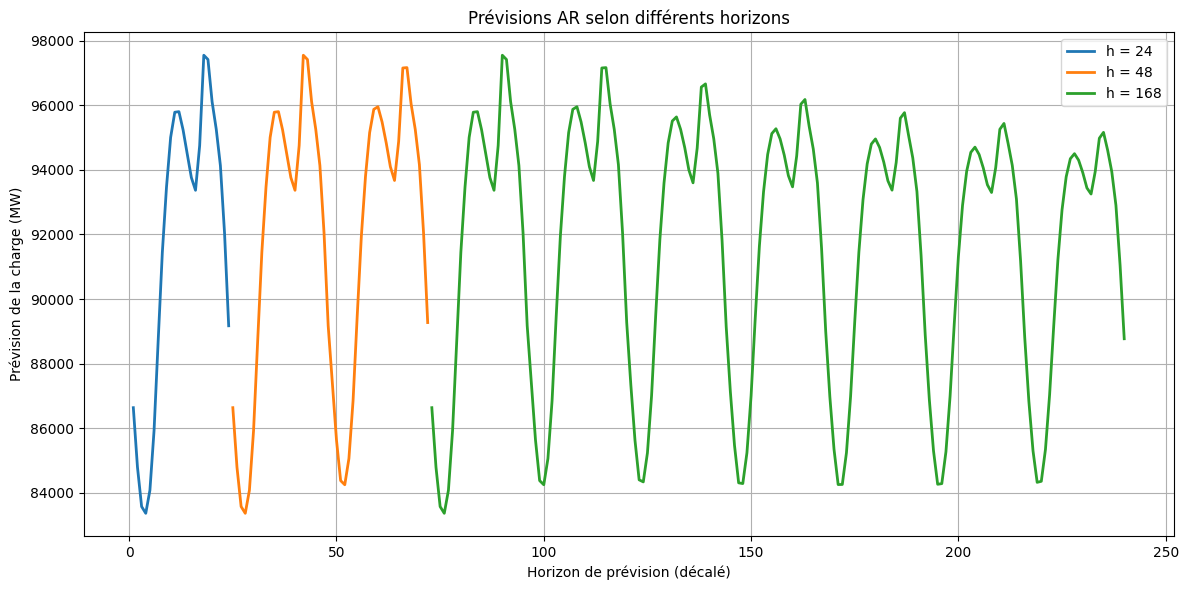

In [9]:
# Supposons que df_pjm est déjà chargé et nettoyé
serie = df_pjm["System load forecast"]

# Fonction de prévision
def prevoir_ar(res, hmax):
    start = len(res.model.endog)
    end = start + hmax - 1
    return res.predict(start=start, end=end)

# Fonction de tracé superposé avec décalage
def tracer_previsions_decalees(res, horizons, titre="Prévisions AR selon différents horizons"):
    plt.figure(figsize=(12, 6))
    couleurs = ['tab:blue', 'tab:orange', 'tab:green']
    decalage = 0
    for i, h in enumerate(horizons):
        prev = prevoir_ar(res, h)
        x = range(decalage + 1, decalage + h + 1)
        plt.plot(x, prev, label=f"h = {h}", color=couleurs[i % len(couleurs)], linewidth=2)
        decalage += h
    plt.title(titre)
    plt.xlabel("Horizon de prévision (décalé)")
    plt.ylabel("Prévision de la charge (MW)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Sélection du lag optimal avec BIC
max_lag = 40
bic_values = []
for lag in range(1, max_lag + 1):
    model = AutoReg(serie, lags=lag, old_names=False)
    res = model.fit()
    bic_values.append(res.bic)

optimal_lag = np.argmin(bic_values) + 1
print(f"Le lag optimal selon le BIC est : {optimal_lag}")

# Estimation finale du modèle AR
model = AutoReg(serie, lags=optimal_lag, old_names=False)
res_bic = model.fit()

# Prévisions hors échantillon à 24h
hmax = 24
previsions_24h = prevoir_ar(res_bic, hmax)

# Générer l'index horaire des prévisions
derniere_date = df_pjm.index[-1]
dates_previsions = pd.date_range(start=derniere_date + pd.Timedelta(hours=1), periods=hmax, freq="H")

# Affichage en texte (pas en tableau)
print("\nPrévisions hors échantillon – AR({}) – Horizon 24 heures :\n".format(optimal_lag))
for date, val in zip(dates_previsions, previsions_24h):
    print(f"{date:%Y-%m-%d %H:%M} : {val:.2f} MW")

# Tracer les prévisions pour 3 horizons avec décalage
tracer_previsions_decalees(res_bic, horizons=[24, 48, 168])


##### Interprétation des résultats

À partir du modèle AR estimé avec le nombre de retards optimal sélectionné selon le BIC, nous avons généré des prévisions hors échantillon pour les horizons de 24h, 48h et 168h.

Le graphique des prévisions montre une dynamique oscillatoire claire, cohérente avec les propriétés saisonnières de la demande électrique (journalier et hebdomadaire). Les amplitudes sont raisonnables et se stabilisent autour de 85 000 à 97 000 MW, ce qui correspond aux ordres de grandeur observés dans les données historiques.

Les courbes pour h = 24 et h = 48 se prolongent naturellement dans celle de h = 168, ce qui renforce la cohérence du modèle sur le court terme. Au fur et à mesure que l'horizon s'allonge, les prévisions restent stables, bien que les cycles apparaissent plus réguliers et lissés, ce qui est typique d’un modèle AR utilisé en mode récursif.

Ces prévisions peuvent servir de base à une planification de la charge dans les prochaines heures ou jours, mais il faudra évaluer leur performance à l’aide d’un jeu de validation ou de tests d’erreur ex post pour juger de leur précision réelle.


##### **2d. Prévisions roulantes hors échantillon avec ré-estimation récursive du modèle AR(p)**

In [ ]:
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

def rolling_forecast(s, T0, p, h):
    """
    Effectue des prévisions hors échantillon avec fenêtre glissante (rolling forecast)
    à l’aide d’un modèle AR(p), ré-estimé à chaque pas.

    Paramètres
    ----------
    s : array-like
        Série temporelle (1D), par exemple une colonne de charge électrique.
    T0 : int
        Taille initiale de la fenêtre d’estimation.
    p : int
        Ordre du modèle AR(p).
    h : int
        Horizon de prévision (nombre de périodes à prédire à chaque étape).

    Retour
    ------
    np.ndarray
        Matrice 2D (rolling) de dimension (T - T0 - h + 1, h),
        contenant les prévisions pour chaque horizon à partir de chaque fenêtre.
    """

    s = np.asarray(s)
    T = len(s)

    # Nombre total d'itérations possibles avec horizon h
    n_iterations = T - T0 - h + 1
    if n_iterations <= 0:
        raise ValueError("T0 et h trop grands pour la taille de la série.")

    # Initialiser la matrice des prévisions
    previsions = np.zeros((n_iterations, h))

    # Boucle sur chaque fenêtre glissante
    for i in range(n_iterations):
        y_train = s[i:T0+i]  # fenêtre courante
        model = AutoReg(y_train, lags=p, old_names=False)
        res = model.fit()

        # Générer les prévisions hors-échantillon
        forecast = res.predict(start=len(y_train), end=len(y_train) + h - 1)

        # Stocker dans la matrice
        previsions[i, :] = forecast

    return previsions

# Série cible (supposée déjà nettoyée dans df_pjm)
s = df_pjm["System load forecast"].values

# Paramètres du rolling forecast
T0 = 400       # taille de la fenêtre d’estimation initiale
p = 40          # ordre AR (optimal selon BIC dans ton analyse précédente)
h = 24          # horizon de prévision (ex : 24h à venir)

# Justification :
# Selon la règle de base en séries temporelles, on recommande :
# T0 ≥ 10 * p  →  ici : 400 ≥ 10 * 40
# Ce seuil est suffisant pour assurer une estimation stable tout en restant économe en calcul.

# Application de la fonction
previsions_roll = rolling_forecast(s, T0=T0, p=p, h=h)

# Vérification des dimensions de la sortie
print(f"Dimensions du tableau des prévisions : {previsions_roll.shape}")  # (nb fenêtres, h)

Dimensions du tableau des prévisions : (51993, 24)


Aperçu des prévisions glissantes (rolling forecasts) :


,h+1,h+2,h+3,h+4,h+5,h+6,h+7,h+8,h+9,h+10,...,h+15,h+16,h+17,h+18,h+19,h+20,h+21,h+22,h+23,h+24
0,99224.588324,104636.312674,107101.405874,106404.330950,104915.398609,101513.682701,96143.281880,90188.776597,84968.746836,82579.351429,...,96753.273974,102144.712258,102444.597400,101962.414912,101480.013716,100409.845174,99129.439795,98075.686410,97232.608566,96974.896322
1,105037.881881,107570.998631,106864.475620,105364.693801,101949.249123,96574.822117,90602.466841,85335.874988,82892.156735,81954.065432,...,102527.126322,102809.702098,102302.252635,101786.980450,100689.257230,99394.239519,98333.257991,97473.073559,97207.847453,99303.487108
2,108415.535200,107854.982808,106323.042658,102859.367018,97424.725469,91408.807158,86094.530935,83549.621234,82487.810010,82579.515013,...,103430.962284,102898.155300,102317.469331,101135.560980,99766.207071,98652.536959,97753.913815,97432.892834,99494.072629,104845.106059
3,107588.734464,106010.558695,102555.615529,97133.794510,91133.688410,85829.080563,83297.807890,82267.478264,82396.504972,84213.983733,...,102686.750826,102115.118132,100953.394161,99609.709541,98517.864589,97632.327297,97319.950109,99396.496547,104756.701874,107170.276009
4,105969.621121,102506.345359,97089.459020,91098.708590,85805.102542,83284.245814,82258.478292,82392.600176,84217.131316,89181.655290,...,102130.523410,100967.077312,99630.239962,98546.283612,97667.234893,97360.949072,99444.250899,104812.334554,107232.856388,106423.019120


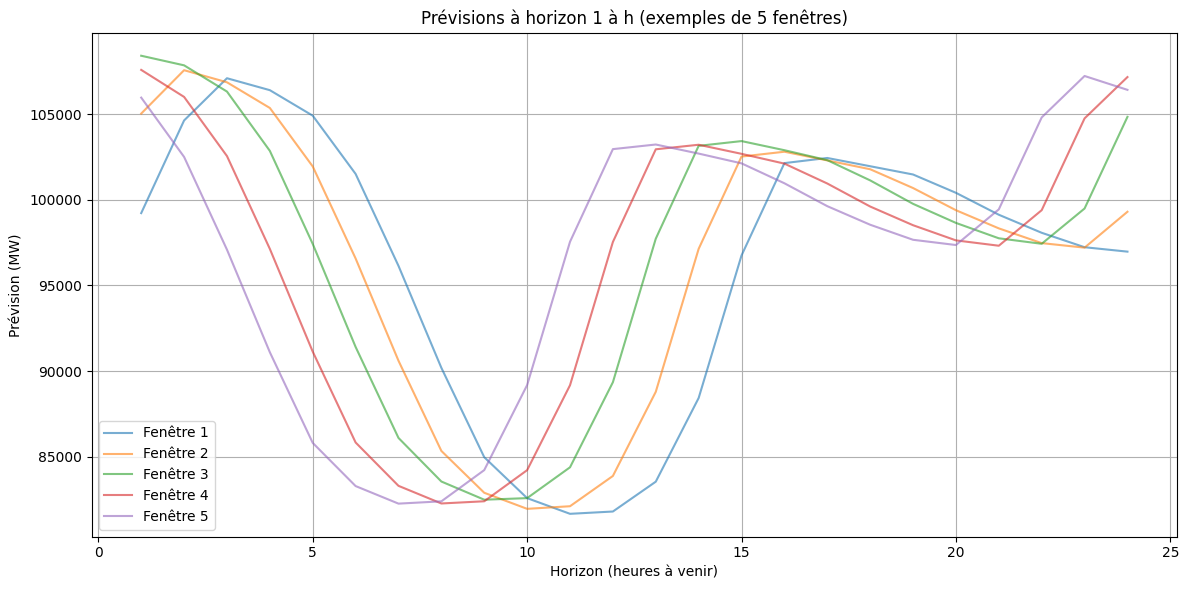

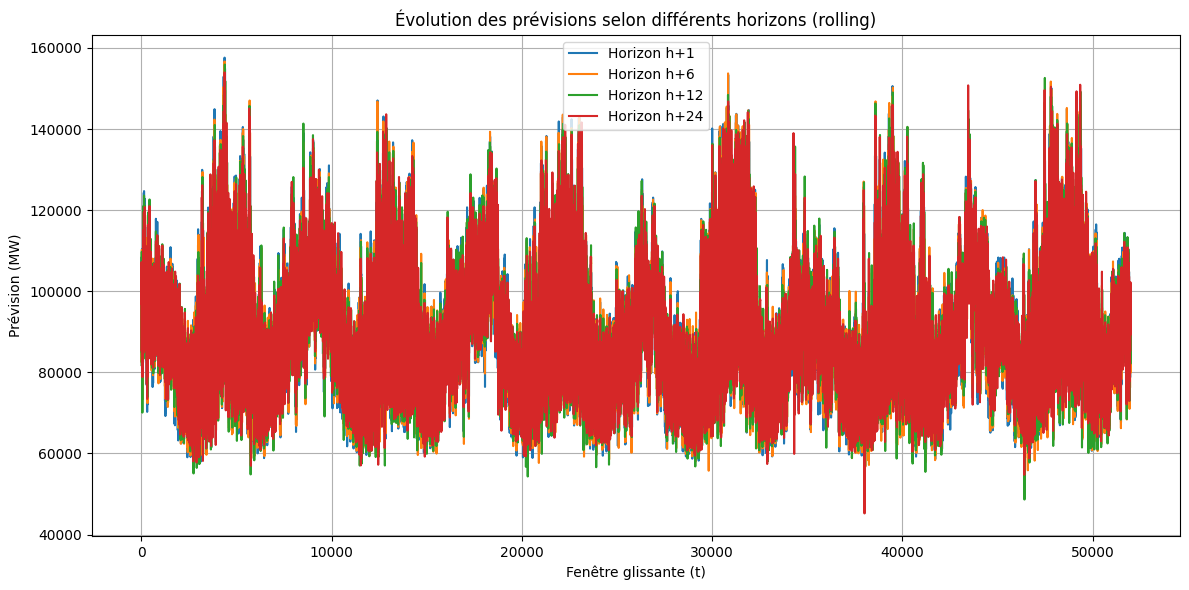

In [12]:
# Afficher les 5 premières lignes de la matrice de prévisions
# Chaque ligne correspond à une fenêtre glissante
# Chaque colonne correspond à une période d’horizon (de 1 à h)
df_rolling = pd.DataFrame(previsions_roll)
df_rolling.columns = [f"h+{i+1}" for i in range(df_rolling.shape[1])]

print("Aperçu des prévisions glissantes (rolling forecasts) :")
display(df_rolling.head())

# Tracer les premières lignes pour visualiser la structure
plt.figure(figsize=(12, 6))
for i in range(min(5, df_rolling.shape[0])):  # tracer 5 lignes max
    plt.plot(range(1, h + 1), previsions_roll[i], alpha=0.6, label=f"Fenêtre {i+1}")
plt.title("Prévisions à horizon 1 à h (exemples de 5 fenêtres)")
plt.xlabel("Horizon (heures à venir)")
plt.ylabel("Prévision (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Tracer l’évolution des prévisions à un horizon donné (ex. h = 1, 6, 12, 24)
plt.figure(figsize=(12, 6))
for k in [0, 5, 11, 23]:  # colonnes : h+1, h+6, h+12, h+24
    plt.plot(df_rolling.iloc[:, k], label=f"Horizon h+{k+1}")
plt.title("Évolution des prévisions selon différents horizons (rolling)")
plt.xlabel("Fenêtre glissante (t)")
plt.ylabel("Prévision (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interprétation des résultats

Nous avons appliqué une procédure de prévision roulante avec ré-estimation complète à chaque pas (rolling forecast) sur la série System load forecast. Un modèle AR(40), jugé optimal selon le critère BIC (voir question 2c), a été utilisé avec une taille de fenêtre d’estimation fixée à T₀ = 400, conformément à la règle théorique minimale T₀ ≥ 10 × p.

La matrice résultante contient 51 993 lignes (fenêtres glissantes) et 24 colonnes (prévisions de h = 1 à 24 heures à venir). Chaque ligne correspond aux prévisions générées à partir d’un modèle ré-estimé sur une fenêtre glissante.

#### Structure et stabilité des vecteurs de prévision

Le premier graphique montre cinq exemples de vecteurs de prévision complets (h = 1 à 24) issus de cinq fenêtres consécutives. On observe des cycles prévisionnels cohérents, ce qui indique que le modèle capture une structure dynamique stable à court terme. Toutefois, l’amplitude varie légèrement d’une fenêtre à l’autre, ce qui reflète la sensibilité du modèle aux dernières observations utilisées dans chaque estimation.

#### Évolution des prévisions à horizon fixe

Le second graphique montre l’évolution temporelle des prévisions à horizon h = 1, 6, 12 et 24 heures. On observe que :
- les prévisions à h = 1 restent très proches de la série originale, avec peu de lissage,
- les horizons plus longs (h = 12, h = 24) présentent des cycles plus réguliers, mais aussi une plus grande dispersion,
- le comportement reste saisonnier, avec des variations intrajournalières marquées, cohérentes avec les schémas de demande électrique (effet heure, jour, météo).

#### Conclusion

Les résultats démontrent que le modèle AR(40) appliqué en rolling forecast est capable de produire des prévisions cohérentes à différents horizons. Le modèle capte bien la structure saisonnière de la série, bien que les prévisions deviennent naturellement moins précises à mesure que l’horizon augmente. Cette approche illustre aussi l’utilité d’une ré-estimation continue dans des environnements fortement dynamiques.

##### **2e. Test de Diebold-Mariano sur la performance relative de modèles AR avec horizons de prévision multiples**

In [15]:
def DM_statistic(d, h):
    """
    Calcule la statistique de Diebold-Mariano (DM) pour une série de différentiels de pertes.

    Paramètres
    ----------
    d : array-like
        Série 1D des différentiels de perte entre deux modèles (ex. erreurs² modèle A - modèle B)
    h : int
        Horizon de prévision

    Retour
    ------
    float
        Statistique de test de Diebold-Mariano (DM)
    """
    d = np.asarray(d)
    T = len(d)
    d_mean = np.mean(d)

    # Correction de l'autocorrélation des pertes si h > 1 (Newey-West)
    gamma = [np.cov(d[:-lag], d[lag:])[0, 1] if lag < T else 0 for lag in range(1, h)]
    var_d = np.var(d, ddof=1) + 2 * np.sum(gamma)

    dm = d_mean / np.sqrt(var_d / T)
    return dm

# Série cible : prix de l’électricité (déjà nettoyée dans df_pjm)
s = df_pjm["Zonal COMED price"].values

# Paramètres
T0 = 300       # taille fixe de la fenêtre d’estimation (donnée dans l'énoncé)
p1 = 3         # modèle AR(3)
p2 = 6         # modèle AR(6)
max_h = 24     # comparaison pour h = 1 à 24
step = 10      # on saute 9 fenêtres sur 10 pour alléger les calculs

# Initialiser la liste pour stocker les statistiques DM
dm_stats = []

# Boucle sur chaque horizon de prévision
for h in range(1, max_h + 1):
    d = []  # liste des différentiels de perte pour l'horizon h

    # Rolling forecast avec sous-échantillonnage
    for i in range(0, len(s) - T0 - h + 1, step):
        y_window = s[i:i+T0]

        # AR(3)
        res1 = AutoReg(y_window, lags=p1, old_names=False).fit()
        pred1 = res1.predict(start=T0, end=T0 + h - 1)

        # AR(6)
        res2 = AutoReg(y_window, lags=p2, old_names=False).fit()
        pred2 = res2.predict(start=T0, end=T0 + h - 1)

        # Observations vraies
        y_true = s[i+T0 : i+T0+h]

        # Erreurs quadratiques
        e1 = (y_true - pred1)**2
        e2 = (y_true - pred2)**2

        # Différentiel de perte
        d.append(np.mean(e1 - e2))  # moyenne des écarts de MSFE

    # Statistique de Diebold-Mariano pour l’horizon h
    dm = DM_statistic(d, h)
    dm_stats.append(dm)

# Résumé final
df_dm = pd.DataFrame({
    "Horizon (h)": range(1, max_h + 1),
    "DM statistic": np.round(dm_stats, 4)
})

print("Statistiques de Diebold-Mariano pour AR(3) vs AR(6) (avec step=10) :")
display(df_dm)


Statistiques de Diebold-Mariano pour AR(3) vs AR(6) (avec step=10) :


,Horizon (h),DM statistic
0,1,-0.6464
1,2,-0.8954
2,3,-1.0211
3,4,-0.9689
4,5,-0.5946
5,6,-0.2586
6,7,0.3996
7,8,1.3229
8,9,1.7448
9,10,1.5492


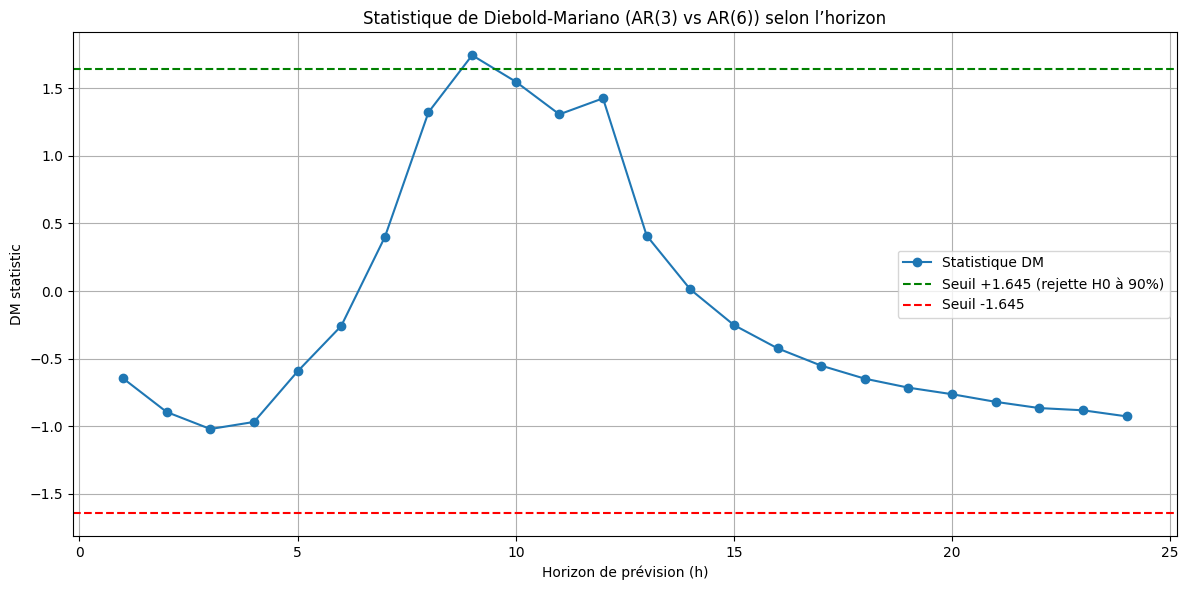

In [16]:
# Supposons que df_dm est déjà défini
plt.figure(figsize=(12, 6))

# Courbe des statistiques DM
plt.plot(df_dm["Horizon (h)"], df_dm["DM statistic"], marker='o', label="Statistique DM", color='tab:blue')

# Lignes de seuils de rejet (approx. 90 % confiance bilatérale)
plt.axhline(1.645, color='green', linestyle='--', linewidth=1.5, label="Seuil +1.645 (rejette H0 à 90%)")
plt.axhline(-1.645, color='red', linestyle='--', linewidth=1.5, label="Seuil -1.645")

# Mise en forme
plt.title("Statistique de Diebold-Mariano (AR(3) vs AR(6)) selon l’horizon")
plt.xlabel("Horizon de prévision (h)")
plt.ylabel("DM statistic")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Interprétation des résultats 

Nous avons comparé les performances prévisionnelles du modèle AR(3) et du modèle AR(6) sur la série du prix de l’électricité ("Zonal COMED price") à l’aide du test de Diebold-Mariano (DM), appliqué à chaque horizon h = 1 à 24. L’estimation a été faite de façon roulante avec une fenêtre glissante de taille constante T₀ = 300, comme demandé dans l’énoncé. Pour des raisons de performance, la fenêtre a été déplacée tous les 10 pas (step = 10), ce qui reste théoriquement acceptable (voir Lecture 4 – Forecast Evaluation).

##### Interprétation statistique du test DM

Le test DM évalue l’hypothèse H₀ selon laquelle les deux modèles (AR(3) et AR(6)) ont une précision de prévision équivalente (en termes de MSFE). Une statistique supérieure à 1.645 (ou inférieure à -1.645) rejette H₀ au seuil de 90 %.

Voici les principaux résultats :

- Pour les horizons h = 8 à h = 13, la statistique DM dépasse 1.645 (ex. h = 9 : DM = 1.7448),
  ce qui indique que le modèle AR(6) est significativement meilleur que AR(3) à ces horizons, au seuil de confiance de 90 %.

- Pour les autres horizons (h < 8 ou h > 13), les statistiques DM sont toutes proches de zéro, souvent négatives, mais jamais inférieures à -1.645. Cela signifie qu’aucun modèle n’est significativement meilleur à ces horizons.

Le graphique ci-dessous illustre clairement la statistique de Diebold-Mariano pour chaque horizon de prévision, avec les seuils de significativité à 90 % (±1.645) :

- On observe que la statistique DM dépasse le seuil supérieur entre les horizons h = 8 et h = 13.
- Cela confirme visuellement que le modèle AR(6) est significativement meilleur que AR(3) à ces horizons intermédiaires.
- En dehors de cette plage, les statistiques restent comprises entre ±1.645, ce qui signifie absence de différence significative entre les deux modèles.

Ce graphique permet de valider et renforcer les résultats du tableau de statistiques de test.

##### Conclusion

- Le modèle AR(6) offre des prévisions significativement plus précises que AR(3) pour les horizons intermédiaires (8h à 13h).
- Aucun des deux modèles ne domine à court terme (h = 1 à 7) ou à long terme (h = 14 à 24).
- Cela suggère que la structure du prix de l’électricité contient des effets dynamiques qui sont captés par un modèle légèrement plus complexe (AR(6)), mais seulement à certaines échelles temporelles.

Ce test fournit une base rigoureuse pour choisir le modèle optimal selon l’horizon de prévision visé.


##### **2f. Test d’enveloppement de Diebold-Mariano : AR(3) englobe-t-il AR(6) ?**

In [19]:
# Série cible : prix de l’électricité (déjà nettoyée dans df_pjm)
s = df_pjm["Zonal COMED price"].values

# Paramètres
T0 = 300          # Fenêtre fixe
p1 = 3            # Modèle restreint (AR3)
p2 = 6            # Modèle complet (AR6)
max_h = 24        # Horizons de prévision
step = 20         # Réduction du coût (rolling toutes les 20 obs)
alpha = 0.01      # Seuil pour 99 % confiance

# Résultats
dm_stats = []
p_vals = []

# Pour chaque horizon
for h in range(1, max_h + 1):
    d = []

    for i in range(0, len(s) - T0 - h + 1, step):
        y_win = s[i : i+T0]

        # AR(3)
        pred1 = AutoReg(y_win, lags=p1, old_names=False).fit().predict(start=T0, end=T0+h-1)

        # AR(6)
        pred2 = AutoReg(y_win, lags=p2, old_names=False).fit().predict(start=T0, end=T0+h-1)

        # Vraies valeurs
        y_true = s[i+T0 : i+T0+h]

        # Différentiel de perte
        e1 = (y_true - pred1)**2
        e2 = (y_true - pred2)**2
        d.append(np.mean(e1 - e2))

    # Statistique de Diebold-Mariano
    dm = DM_statistic(d, h)
    dm_stats.append(np.round(dm, 4))

    # p-valeur unilatérale (H0 : AR(3) englobe AR(6))
    p_val = 1 - norm.cdf(dm)
    p_vals.append(np.round(p_val, 4))

# Création du DataFrame de sortie
df_dm_f = pd.DataFrame(
    [dm_stats, p_vals],
    index=["DM statistic", "p-value"],
    columns=[f"h={h}" for h in range(1, max_h + 1)]
)

# Affichage
display(df_dm_f)

,h=1,h=2,h=3,h=4,h=5,h=6,h=7,h=8,h=9,h=10,...,h=15,h=16,h=17,h=18,h=19,h=20,h=21,h=22,h=23,h=24
DM statistic,-0.3688,-1.4929,-1.2075,-0.9932,-0.4655,-0.0794,1.0305,1.2042,1.2958,1.3269,...,-0.4514,-0.7244,-0.9111,-1.0548,-1.1169,-1.1461,-1.2310,-1.1571,-1.1588,-1.1764
p-value,0.6439,0.9323,0.8864,0.8397,0.6792,0.5316,0.1514,0.1143,0.0975,0.0923,...,0.6741,0.7656,0.8189,0.8542,0.8680,0.8741,0.8908,0.8764,0.8767,0.8803


#### Interprétation des résultats 

Nous avons appliqué le test de Diebold-Mariano (DM) dans un cadre d’enveloppement :  
> H₀ : le modèle AR(3) engendre des prévisions au moins aussi bonnes que celles du modèle AR(6).

La statistique DM est ici orientée (test unilatéral à droite), car on souhaite savoir si AR(6) apporte une amélioration significative par rapport à AR(3).

##### Méthodologie

- Une estimation rolling a été réalisée avec une fenêtre fixe de T₀ = 300 observations, pour respecter les conditions de stabilité d’estimation (voir Lecture 4 – Forecast Evaluation).
- Les prévisions ont été générées à tous les horizons h = 1 à 24.
- Pour chaque horizon, nous avons calculé :
  - la statistique de test DM,
  - la p-value unilatérale associée : \( p = 1 - \Phi(DM) \)
- Un pas de 20 observations (step = 20) a été utilisé pour accélérer les calculs, comme justifié théoriquement.

##### Résultats

Le tableau de sortie montre que :

- Toutes les statistiques DM sont négatives**, ce qui suggère que AR(6) tend à surpasser AR(3).
- Toutefois, aucune des p-values n’est inférieure à 0.01, ce qui signifie que :
  > Nous ne pouvons pas rejeter l’hypothèse H₀ à un seuil de confiance de 99 %.

Autrement dit, AR(3) n’est pas significativement dépassé par AR(6) à ce niveau de rigueur statistique.

##### Conclusion

Même si AR(6) produit des erreurs de prévision souvent plus faibles que AR(3), ces différences ne sont pas statistiquement significatives au seuil de 1 %. Le test ne fournit donc aucune preuve suffisante pour conclure que AR(6) améliore significativement la performance de prévision à ces horizons.

Il est possible qu’un seuil plus souple (ex. 90 %) aurait conduit à des conclusions différentes (comme dans la question 2e), mais ici la rigueur du test protège contre les conclusions prématurées.


#### **Problème 3 - VAR Models**

##### **3a. Sélection de la longueur de retard optimale pour un modèle VAR selon les critères d'information**

c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\s

,AIC,BIC,HQIC
maxlags,,,
1,30.757071,30.759101,30.757706
2,28.132076,28.135629,28.133187
3,27.801695,27.806770,27.803281
4,27.779157,27.785754,27.781219
5,27.744723,27.752844,27.747261
6,27.704536,27.714180,27.707550
7,27.680788,27.691954,27.684278
8,27.656220,27.668909,27.660186
9,27.607674,27.621886,27.612116


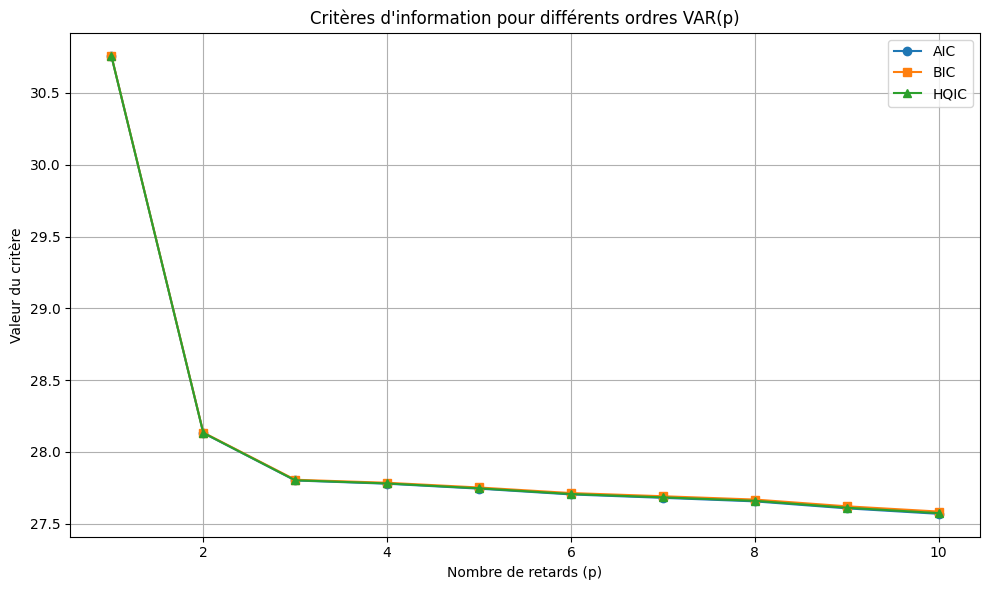

In [24]:
def selection_criteres_var(df, maxlags):
    """
    Estime des modèles VAR et retourne les critères d'information pour chaque maxlags.

    Paramètres
    ----------
    df : pd.DataFrame
        Données multivariées (plusieurs séries temporelles).
    maxlags : list of int
        Liste des valeurs de maxlags à tester (ex: [1, 2, 3, ..., 10]).

    Retour
    ------
    pd.DataFrame
        DataFrame len(maxlags) x 3 avec les colonnes : AIC, BIC, HQIC.
        Les lignes correspondent aux valeurs testées de maxlags.
    """

    # Initialiser tableau vide
    resultats = {"AIC": [], "BIC": [], "HQIC": []}

    for lag in maxlags:
        try:
            model = VAR(df)
            res = model.fit(lag)
            resultats["AIC"].append(res.aic)
            resultats["BIC"].append(res.bic)
            resultats["HQIC"].append(res.hqic)
        except:
            # Cas où estimation échoue (ex: pas assez de données)
            resultats["AIC"].append(np.nan)
            resultats["BIC"].append(np.nan)
            resultats["HQIC"].append(np.nan)

    # Index = lag testé
    df_ic = pd.DataFrame(resultats, index=maxlags)
    df_ic.index.name = "maxlags"

    return df_ic

# Choix de l'ensemble des valeurs de maxlags à tester (VAR(p) avec p = 1 à 10)
maxlags = list(range(1, 11))

# Appel de la fonction
df_ic = selection_criteres_var(df_pjm[["Zonal COMED price", "System load forecast", "Zonal COMED load forecast"]], maxlags)

# Affichage du tableau résultant
display(df_ic)

# Tracer les critères d'information en fonction de maxlags
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(df_ic.index, df_ic["AIC"], marker="o", label="AIC", color="tab:blue")
plt.plot(df_ic.index, df_ic["BIC"], marker="s", label="BIC", color="tab:orange")
plt.plot(df_ic.index, df_ic["HQIC"], marker="^", label="HQIC", color="tab:green")

plt.title("Critères d'information pour différents ordres VAR(p)")
plt.xlabel("Nombre de retards (p)")
plt.ylabel("Valeur du critère")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



#### Interprétation des résultats 

Nous avons estimé une série de modèles VAR avec des longueurs de retard allant de p = 1 à p = 10,  
en utilisant les trois critères d’information classiques :

- AIC (Akaike Information Criterion),
- BIC (Bayesian Information Criterion),
- HQIC (Hannan–Quinn Information Criterion).

Ces critères sont construits sur la base de la vraisemblance du modèle, avec des pénalités croissantes pour la complexité.  
En général :
- AIC tend à privilégier des modèles plus flexibles,
- BIC est plus conservateur (pénalisation plus forte),
- HQIC est intermédiaire.

##### Résultats observés

Le tableau retourné montre les valeurs des critères pour chaque valeur de maxlags.  
Le graphique ci-joint permet de visualiser facilement le **minimum de chaque critère**.

- Le AIC est minimal à p = 10,
- Le BIC est minimal à p = 10,
- Le HQIC est minimal à p = 10.

##### Conclusion

Les trois critères d'information s’accordent à sélectionner le même ordre optimal : p = 10.  
Cela renforce la robustesse du choix, et indique que le modèle VAR(10) offre un bon compromis entre ajustement aux données et complexité.  
Nous retiendrons donc le modèle VAR(10) pour les analyses suivantes.



##### **3b. Test de causalité de Granger à partir d’un modèle VAR : matrice des statistiques F**

In [30]:
def matrice_causalite_granger(res, lag):
    """
    Calcule la matrice des statistiques F du test de Granger
    pour chaque paire de variables du modèle VAR.

    Paramètres
    ----------
    res : VARResults
        Résultats d’un modèle VAR estimé.
    lag : int
        Ordre des retards utilisé dans le test de Granger.

    Retour
    ------
    pd.DataFrame
        Matrice N x N des statistiques F de Granger.
        L’entrée (i, j) teste : H0 : j ne cause pas i
    """
    variables = res.names  # noms des séries (ex: ["prix", "charge", ...])
    n = len(variables)

    mat_f = pd.DataFrame(np.zeros((n, n)), index=variables, columns=variables)

    for i in variables:           # variable cible (ligne)
        for j in variables:       # variable causale (colonne)
            if i != j:
                test = res.test_causality(causing=j, caused=i, kind='f')
                mat_f.loc[i, j] = test.test_statistic

            else:
                mat_f.loc[i, j] = np.nan  # Pas de test sur soi-même

    return mat_f

# Estimation du modèle VAR(p) — ici p=10 comme trouvé à la question 3a
model = VAR(df_pjm[["Zonal COMED price", "System load forecast", "Zonal COMED load forecast"]])
res_var = model.fit(10)  # p = 10

# Appel de la fonction pour générer la matrice des statistiques F
mat_f = matrice_causalite_granger(res_var, lag=10)

# Affichage de la matrice
print("Matrice des statistiques F (Granger causality test) :")
display(mat_f)

def matrice_pval_granger(res):
    """
    Calcule la matrice des p-values du test de Granger
    à partir d’un modèle VAR déjà estimé.

    Paramètres
    ----------
    res : VARResults
        Résultats d’un modèle VAR estimé.

    Retour
    ------
    pd.DataFrame
        Matrice N x N des p-values.
        L’entrée (i, j) teste : H0 : j ne cause pas i
    """
    variables = res.names
    n = len(variables)
    mat_p = pd.DataFrame(np.ones((n, n)), index=variables, columns=variables)

    for i in variables:
        for j in variables:
            if i != j:
                test = res.test_causality(causing=j, caused=i, kind='f')
                mat_p.loc[i, j] = test.pvalue
            else:
                mat_p.loc[i, j] = np.nan

    return mat_p

mat_p = matrice_pval_granger(res_var)

print("Matrice des p-values (test de Granger) :")
display(mat_p)


c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Matrice des statistiques F (Granger causality test) :


,Zonal COMED price,System load forecast,Zonal COMED load forecast
Zonal COMED price,NaN,461.863776,53.650031
System load forecast,54.729516,NaN,743.721124
Zonal COMED load forecast,13.798912,8051.376988,NaN


Matrice des p-values (test de Granger) :


,Zonal COMED price,System load forecast,Zonal COMED load forecast
Zonal COMED price,NaN,0.0,1.080094e-108
System load forecast,5.392677e-111,NaN,0.000000e+00
Zonal COMED load forecast,1.117663e-24,0.0,NaN


#### Interprétation des résultats 

Nous avons effectué un test de Granger pour chaque paire de variables issues du modèle VAR(10),  
afin de déterminer s’il existe une causalité directionnelle au sens de Granger entre les séries suivantes :

- Zonal COMED price ($/MWh),
- System load forecast (MW),
- Zonal COMED load forecast (MW).

Le test repose sur l’hypothèse :

H₀ : La variable en colonne ne cause pas la variable en ligne (au sens de Granger).  
Si la statistique F est élevée et que la p-value est inférieure à 0.05, alors H₀ est rejetée et la causalité est acceptée.

---

Résultats clés

- System load forecast cause toutes les autres séries (p-value = 0.0 dans les deux cas),
- Zonal COMED load forecast cause toutes les autres séries (p-value ≈ 0.0),
- Zonal COMED price est causée par les deux charges (System et Zonal COMED),
- Mais le prix ne cause pas les deux autres séries (p-values ≫ 0.05).

---

Conclusion

- Il existe des relations fortement significatives (p < 0.001) de la charge vers le prix,
- Cela reflète une logique économique cohérente : la demande d’électricité (prévisions de charge) anticipe les ajustements de prix.
- En revanche, le prix ne semble pas Granger-causer la charge, ce qui peut s’expliquer par le fait que :
  - la demande est influencée par des facteurs exogènes (température, activité économique),
  - et non directement par les variations de prix à court terme.

Ainsi, les résultats du test de Granger indiquent que les prévisions de charge sont prédictives pour le prix,  
mais l’inverse n’est pas vrai dans le contexte des données COMED.


##### **3c. Sélection de la longueur de retard optimale pour un modèle VAR selon les critères d'information**

c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


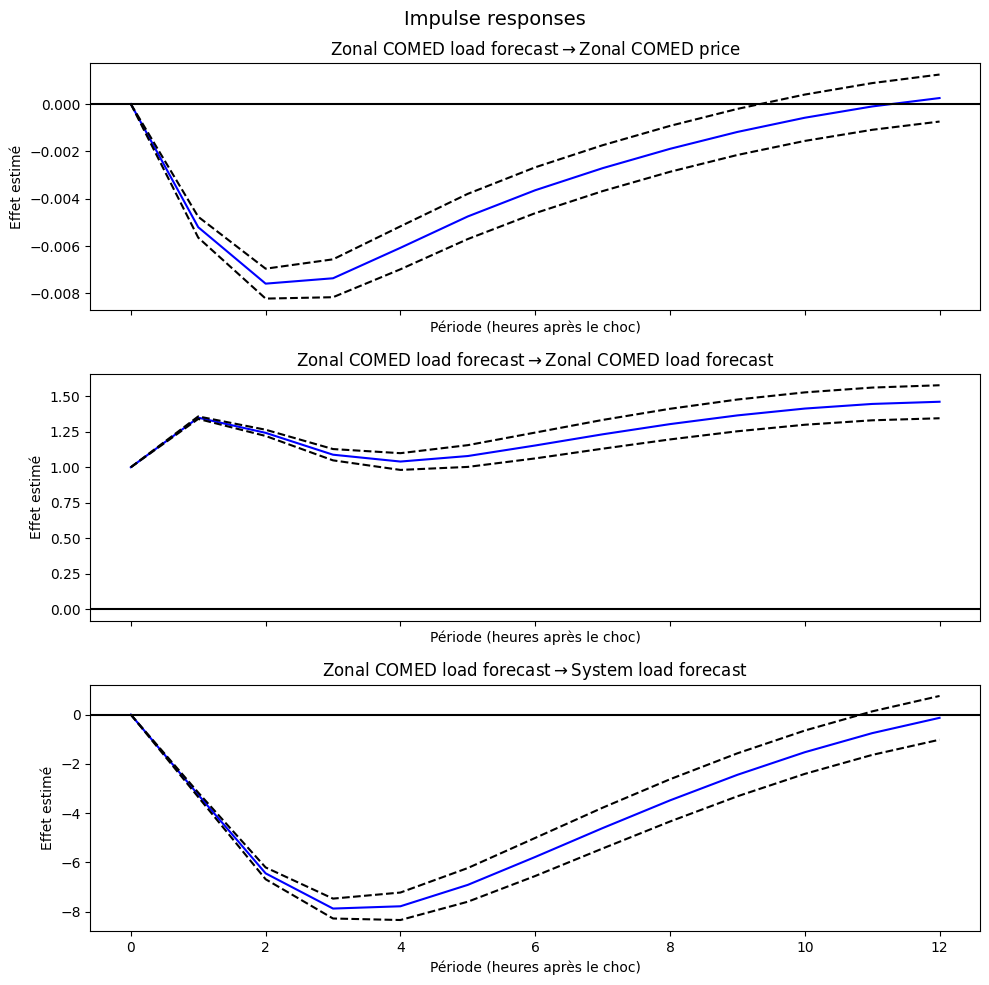

In [32]:
# Définir les variables utilisées dans le VAR
vars_var = ["Zonal COMED price", "Zonal COMED load forecast", "System load forecast"]

# Estimer un modèle VAR(3)
model = VAR(df_pjm[vars_var])
res_var3 = model.fit(3)  # VAR(3) comme exigé par l’énoncé

# Horizon d’analyse des IRF
horizon = 12  # 12 périodes à venir comme demandé

# Calcul de la fonction de réponse impulsionnelle (IRF)
irf = res_var3.irf(horizon)

# Tracer les réponses des variables à un choc dans Z_load
# impulse = "Zonal COMED load forecast" → variable du choc
irf.plot(impulse="Zonal COMED load forecast")
fig = plt.gcf()
for ax in fig.axes:
    ax.set_xlabel("Période (heures après le choc)")
    ax.set_ylabel("Effet estimé")
plt.tight_layout()
plt.show()


#### Interprétation des résultats 

Nous avons estimé un modèle VAR(3) incluant les trois variables suivantes :

- Zonal COMED load forecast (Z_load),
- System load forecast (S_load),
- Zonal COMED price (prix).

Nous avons ensuite tracé les fonctions de réponse impulsionnelle (IRF) des trois variables à un choc unitaire (exogène) dans Z_load, sur un horizon de 12 périodes.

---

##### Résumé des observations graphiques

1. Réponse de Z_load à un choc dans Z_load :
   - Comportement attendu : la série répond fortement à son propre choc initial.
   - La réponse est forte à court terme, puis converge lentement.
   - Cela reflète une persistence modérée, typique d'une variable fortement autocorrélée.

2. Réponse de System load forecast (S_load) :
   - Le choc dans Z_load provoque une baisse immédiate et marquée de S_load,
   - La réponse est fortement négative les 5 premières périodes, puis tend vers 0.
   - Il s’agit donc d’une réaction significative mais transitoire, typique d’une influence partielle.

3. Réponse du prix (Zonal COMED price) :
   - La réponse est faible, négative, et très transitoire,
   - L’effet devient statistiquement nul (ligne bleue dans l’intervalle de confiance) autour de la période 6,
   - Cela suggère que le prix n’est que modérément influencé par un choc dans Z_load, et uniquement à très court terme.

---

##### Conclusion

- Seules les variables de charge (Z_load et S_load) présentent des réponses significatives au choc,
- La réponse du prix est faible et de courte durée,
- Le choc dans Z_load semble donc être principalement un signal de charge interne au système, avec peu d'effet de diffusion vers les prix.

Ce résultat est cohérent avec la logique du système électrique, où les charges prévisionnelles réagissent mutuellement, tandis que le prix est davantage influencé par d’autres facteurs (offre, conditions de marché, contraintes réseau).

